<a href="https://colab.research.google.com/github/cepdnaclk/e19-co544-Bitcoin-Transaction-Analysis-for-Ransomware-Identification/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Upload the dataset to drive and provide the path here

bitcoin_dataset = pd.read_csv('/content/drive/MyDrive/Machine Learning Project/BitcoinHeistData.csv')

### Convert the labels to binary labels

In [ ]:
# Define a function to convert labels to binary
def convert_to_binary(label):
    if label == 'white':
        return 0  # Assign 0 for 'White' class
    else:
        return 1  # Assign 1 for 'Ransomware' class

# Apply the function to create a new binary label column
bitcoin_dataset['label'] = bitcoin_dataset['label'].apply(convert_to_binary)

# Check for missing values in the target variable
missing_target = bitcoin_dataset['label'].isna().sum()
print(f"Number of missing values in target: {missing_target}")

# Check the updated DataFrame
print(bitcoin_dataset.head())

Number of missing values in target: 0
                              address  year  day  length    weight  count  \
0   111K8kZAEnJg245r2cM6y9zgJGHZtJPy6  2017   11      18  0.008333      1   
1  1123pJv8jzeFQaCV4w644pzQJzVWay2zcA  2016  132      44  0.000244      1   
2  112536im7hy6wtKbpH1qYDWtTyMRAcA2p7  2016  246       0  1.000000      1   
3  1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7  2016  322      72  0.003906      1   
4  1129TSjKtx65E35GiUo4AYVeyo48twbrGX  2016  238     144  0.072848    456   

   looped  neighbors       income  label  
0       0          2  100050000.0      1  
1       0          1  100000000.0      1  
2       0          2  200000000.0      1  
3       0          2   71200000.0      1  
4       0          1  200000000.0      1  


## Balance Dataset with oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Assuming 'target' is the name of your target variable column
target = 'label'

# Split the data into features (X) and target (y)
X = bitcoin_df.drop(columns=[target])
y = bitcoin_df[target]

# Initialize the resamplers
smote = SMOTE(random_state=42)

# Apply oversampling (SMOTE)
X_over, y_over = smote.fit_resample(X, y)

# Print the number of samples after resampling
print("Number of samples after oversampling (SMOTE):", X_over.shape[0])

print("\nClass distribution after oversampling (SMOTE):")
print(pd.Series(y_over).value_counts())


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)


Number of samples after oversampling (SMOTE): 5709906

Class distribution after oversampling (SMOTE):
label
1    2854953
0    2854953
Name: count, dtype: int64


## Balance Dataset with Under Sampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

target = 'label'

# Check for missing values in the target variable
missing_target = bitcoin_dataset[target].isna().sum()
print(f"Number of missing values in target: {missing_target}")

# Split the data into features (X) and target (y)
X = bitcoin_dataset.drop(columns=[target])
y = bitcoin_dataset[target]

# Initialize the resamplers
undersample = RandomUnderSampler(random_state=42)

# Apply undersampling
X_under, y_under = undersample.fit_resample(X, y)

# Print the number of samples after resampling
print("Number of samples after undersampling:", X_under.shape[0])

print("\nClass distribution after undersampling:")
print(pd.Series(y_under).value_counts())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

Number of missing values in target: 0
Number of samples after undersampling: 82826

Class distribution after undersampling:
label
0    41413
1    41413
Name: count, dtype: int64


## Feature Transformation

By comparing skewness and Kurtosis of different transformations, features are transformed with yeojohnson transformation



In [ ]:
from sklearn.preprocessing import PowerTransformer

# Select the features for transformation
features_to_transform = ['length', 'weight', 'neighbors', 'income','looped','count']

# Initialize PowerTransformer with the method set to 'yeo-johnson'
yeojohnson_scaler = PowerTransformer(method='yeo-johnson')

# Fit the PowerTransformer on the training data for the selected features
yeojohnson_scaler.fit(X_train[features_to_transform])

# Apply the transformations to the training set for the selected features
X_train_transformed = X_train.copy()
X_train_transformed[features_to_transform] = yeojohnson_scaler.transform(X_train[features_to_transform])

# Apply the same transformations to the test set for the selected features
X_test_transformed = X_test.copy()
X_test_transformed[features_to_transform] = yeojohnson_scaler.transform(X_test[features_to_transform])



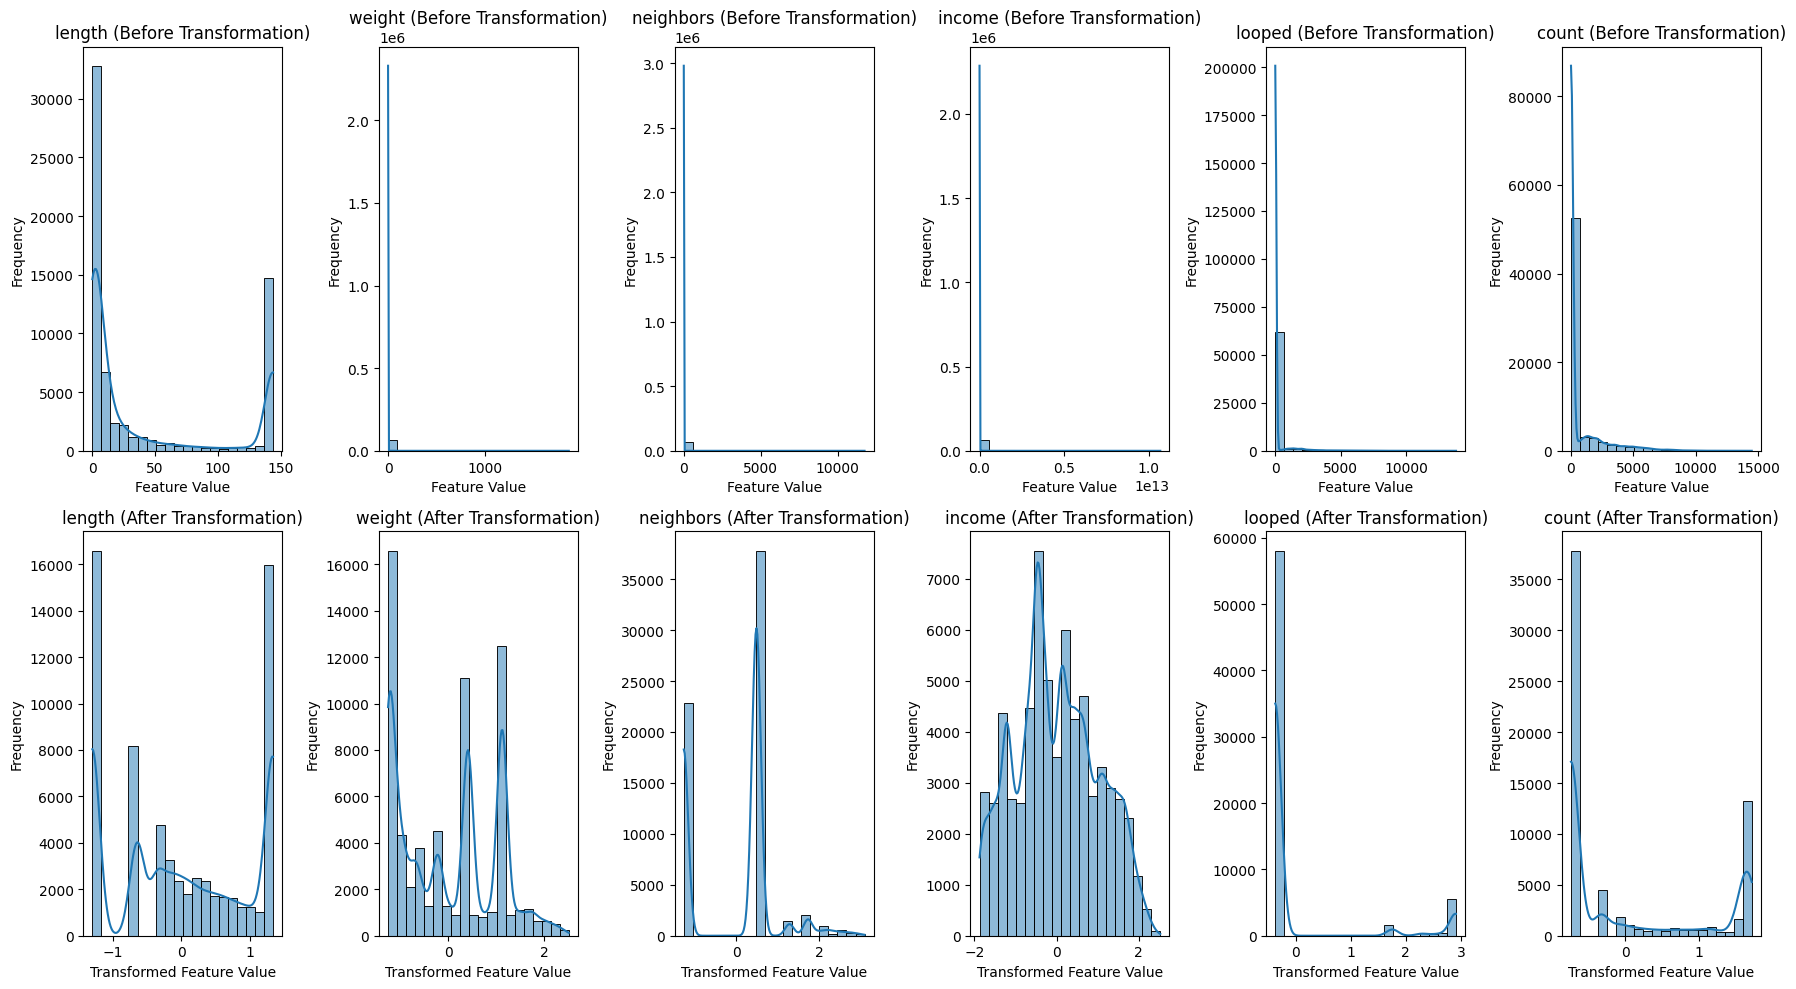

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the histograms/density plots for the transformed features before and after transformation
plt.figure(figsize=(18, 10))

for i, feature in enumerate(features_to_transform, start=1):
    # Before transformation
    plt.subplot(2, len(features_to_transform), i)
    sns.histplot(X_train[feature], bins=20, kde=True)
    plt.title(f'{feature} (Before Transformation)')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

    # After transformation
    plt.subplot(2, len(features_to_transform), i + len(features_to_transform))
    sns.histplot(X_train_transformed[feature], bins=20, kde=True)
    plt.title(f'{feature} (After Transformation)')
    plt.xlabel('Transformed Feature Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Concatenate the transformed data to original datasets

In [ ]:
# Drop the original columns from the concatenated datasets
X_train.drop(features_to_transform, axis=1, inplace=True)
X_test.drop(features_to_transform, axis=1, inplace=True)


# Concatenate the transformed features to the original datasets
X_train = pd.concat([X_train, pd.DataFrame(X_train_transformed, columns=features_to_transform)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(X_test_transformed, columns=features_to_transform)], axis=1)


# Display the first few rows of the concatenated training set after dropping columns
print("Concatenated Training Set (After Dropping Original Columns):")
print(X_train.head())

# Display the first few rows of the concatenated test set after dropping columns
print("\nConcatenated Test Set (After Dropping Original Columns):")
print(X_test.head())


Concatenated Training Set (After Dropping Original Columns):
                                  address  year  day    length    weight  \
44015  13A2JgUYZjQ3hBjARAAbWuV5a8MLgww1bS  2014  161 -1.300075  1.120850   
65783  1FJpENvuGz5QdzgXTY5mXs5ZupgXTmtZ1t  2017   71  0.603883 -0.217205   
532    1EaTs4LJfobgvx1f8gLArT7pGHVP7MAQ19  2014  270  1.336594 -1.246837   
16521  13DeQrEh7s32MwBQvTShg3jWzSGC2bds69  2016  281 -0.646619  1.120850   
68460  1H4scXfteoH3zXfpeG292w89sqAtNRGcKV  2014   13 -0.646619  1.733484   

       neighbors    income    looped     count  
44015   0.486621  1.154860 -0.371180 -0.737415  
65783  -1.260806  0.602798 -0.371180 -0.737415  
532     0.486621  1.083947  2.910705  1.641126  
16521  -1.260806 -0.200523 -0.371180 -0.737415  
68460   0.486621  1.057214 -0.371180 -0.328502  

Concatenated Test Set (After Dropping Original Columns):
                                  address  year  day    length    weight  \
50279  16ucAymaXwPpMVdXtA4FE9sWQH7RrK4P8v  2014  181  

### Box plots of the features

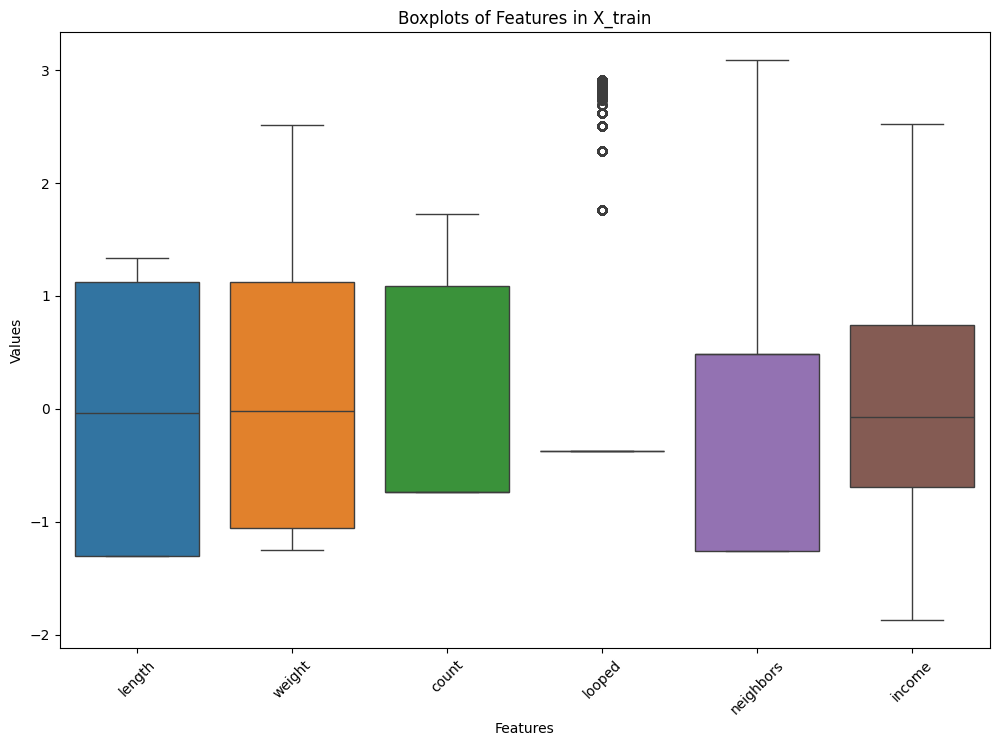

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the features to plot
features_to_plot = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']

# Create boxplots for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=X_train[features_to_plot])
plt.title('Boxplots of Features in X_train')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


## Eliminate Outliers(in the training set)

In [ ]:
from scipy import stats

# Define the threshold for detecting outliers
threshold = 3

# Calculate Z-scores for each transformed feature
z_scores = stats.zscore(X_train[['length', 'weight', 'count', 'looped', 'neighbors', 'income']])

# Identify outliers based on Z-scores
outliers = (np.abs(z_scores) > threshold).any(axis=1)

# # Show the indices of outliers
# print("Indices of outliers:", np.where(outliers)[0])

# Remove outliers from the dataset
X_train = X_train[~outliers]
y_train = y_train[~outliers]

# # Visualize the transformed features after removing outliers
# for feature in features:
#     plot_transformations(bitcoin_dataset_no_outliers[f'{feature}_transformed'], f'{feature} (No Outliers)')



In [ ]:
# Print the number of occurrences of each label in y_train
print("Number of occurrences of each label in y_train:")
print(y_train.value_counts())

# Assess whether the entries are balanced
balanced = y_train.value_counts().std() < 0.1 * y_train.value_counts().mean()

if balanced:
    print("The entries are balanced.")
else:
    print("The entries are not balanced.")

  # Check if X_train and y_train have the same number of samples
if len(X_train) == len(y_train):
    print("X_train and y_train have the same number of samples.")
else:
    print("X_train and y_train have different number of samples.")


Number of occurrences of each label in y_train:
label
1    33113
0    33089
Name: count, dtype: int64
The entries are balanced.
X_train and y_train have the same number of samples.


drop address, year and day because they show no correlation with target

In [ ]:
# Define the columns to drop
columns_to_drop = ['address', 'year', 'day']

# Drop the columns from the training set
X_train_final = X_train.drop(columns=columns_to_drop)

# Drop the columns from the test set
X_test_final = X_test.drop(columns=columns_to_drop)

# Display the first few rows of the modified training set
print("Training set after dropping 'address', 'year', and 'day' columns:")
print(X_train_final.head())

# Display the first few rows of the modified test set
print("\nTest set after dropping 'address', 'year', and 'day' columns:")
print(X_test_final.head())


Training set after dropping 'address', 'year', and 'day' columns:
         length    weight  neighbors    income    looped     count
44015 -1.300075  1.120850   0.486621  1.154860 -0.371180 -0.737415
65783  0.603883 -0.217205  -1.260806  0.602798 -0.371180 -0.737415
532    1.336594 -1.246837   0.486621  1.083947  2.910705  1.641126
16521 -0.646619  1.120850  -1.260806 -0.200523 -0.371180 -0.737415
68460 -0.646619  1.733484   0.486621  1.057214 -0.371180 -0.328502

Test set after dropping 'address', 'year', and 'day' columns:
         length    weight  neighbors    income    looped     count
50279  1.079630 -1.244987   2.198448  1.834007  1.755501  0.222302
42409  1.336594 -1.246344   0.486621 -0.118610 -0.371180  1.679917
29233  1.336594 -1.241652   0.486621 -1.280445  2.910729  1.665555
44591  0.717375  1.135659   1.726037  1.532431 -0.371180  0.957791
15625  0.356441  0.410788   0.486621 -0.096286 -0.371180 -0.737415


Feature Scaling:

For the four different models - SVM, Logistic Regression, XGBoost, and Random Forest - the choice of scalers may vary depending on the characteristics of your data and the algorithms themselves. Here's a general guideline for selecting scalers for each model:

### SVM:
- **Scaler**: MinMaxScaler or StandardScaler.
- **Reasoning**: SVM is sensitive to the scale of the features since it uses a distance-based metric to classify data points. Scaling the features to a similar range can improve the performance of SVM. MinMaxScaler may be preferable if you're using SVM with a kernel like RBF, as it bounds the data to a fixed range, preventing large values from dominating the distance calculations.

### Logistic Regression:
- **Scaler**: StandardScaler.
- **Reasoning**: Logistic Regression typically assumes that features are normally distributed. StandardScaler, which scales the data to have a mean of 0 and a standard deviation of 1, aligns with this assumption and is commonly used with logistic regression. It preserves the shape of the distribution and is suitable for linear models.

### XGBoost:
- **Scaler**: None or MinMaxScaler.
- **Reasoning**: XGBoost is a tree-based ensemble method and is inherently robust to the scale of features. You can choose not to scale the features when using XGBoost. However, if you want to scale the features, MinMaxScaler can be used to bound the features to a specific range, ensuring consistency across the trees.

### Random Forest:
- **Scaler**: None or MinMaxScaler.
- **Reasoning**: Similar to XGBoost, Random Forest is a tree-based ensemble method and is not sensitive to the scale of features. You can choose not to scale the features when using Random Forest. However, if you prefer to scale the features, MinMaxScaler can be used for consistency across the trees.

### Final Considerations:
- For SVM and Logistic Regression, scaling is generally recommended to improve performance.
- For tree-based models like XGBoost and Random Forest, scaling is optional and may not significantly impact performance. However, if you prefer consistency or plan to compare results with other models, you can use MinMaxScaler.

It's important to experiment with different scalers and evaluate their effects on model performance using cross-validation or other validation techniques to determine the optimal approach for your specific dataset and modeling goals.



## Standard Scaled dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_final)

# Transform the test data using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test_final)



In [ ]:
import pandas as pd

# Reset the indices of the features and labels
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Concatenate the scaled training features and labels
training_Set = pd.concat([pd.DataFrame(X_train_scaled, columns=X_train_final.columns), y_train], axis=1)

# Concatenate the scaled test features and labels
test_set = pd.concat([pd.DataFrame(X_test_scaled, columns=X_test_final.columns), y_test], axis=1)

# Save the concatenated datasets to CSV files
training_Set.to_csv('bitcoin_training_dataset.csv', index=False)
test_set.to_csv('bitcoin_test_dataset.csv', index=False)


## Min-Max Scaled Dataset


In [ ]:
# Select the numerical features to scale
numerical_features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']

# Initialize the scalers
minmax_scaler = MinMaxScaler()


# Scale the features using MinMaxScaler
minmax_scaled_features = minmax_scaler.fit_transform(bitcoin_df[numerical_features])

# Create DataFrames with scaled features
minmax_scaled_df = pd.DataFrame(minmax_scaled_features, columns=numerical_features)

# Concatenate the scaled features with non-scaled features
minmax_scaled_df = pd.concat([bitcoin_df.drop(columns=numerical_features), minmax_scaled_df], axis=1)

print("MinMax Scaled DataFrame:")
print(minmax_scaled_df.head())

# Use MinMax Scaled dataset from this point onwards
bitcoin_df = minmax_scaled_df

MinMax Scaled DataFrame:
     year    day  label    length    weight     count  looped  neighbors  \
0  2017.0   11.0    1.0  0.609728  0.012518  0.000000     0.0    0.43121   
1  2016.0  132.0    1.0  0.778238  0.000370  0.000000     0.0    0.00000   
2  2016.0  246.0    1.0  0.000000  0.650865  0.000000     0.0    0.43121   
3  2016.0  322.0    1.0  0.870884  0.005900  0.000000     0.0    0.43121   
4  2016.0  238.0    1.0  1.000000  0.101237  0.909528     0.0    0.00000   

     income  
0  0.259310  
1  0.259217  
2  0.377801  
3  0.193497  
4  0.377801  


## Dimension Reduction(if required):

The first principal component explains almost all of the variance in the data (close to 100%), while the subsequent components explain very little variance. In this case, retaining just one principal component would capture the majority of the variance in the data.

Therefore, this dataset can be reduced to one dimension.

In [ ]:
from sklearn.decomposition import PCA

# Assume bitcoin_df is your DataFrame containing the features
# Select the numerical features to apply PCA
numerical_features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income']

# Extract the numerical features
X = bitcoin_df[numerical_features]

# Initialize PCA with the desired number of components
pca = PCA(n_components=2)  # You can specify the number of components you want to retain

# Fit PCA to the feature matrix
pca.fit(X)

# Transform the feature matrix to its principal components
X_pca = pca.transform(X)

# X_pca will contain the reduced-dimensional representation of the data
reduced_df = pd.DataFrame(X_pca)

# Use dimension reduced data frame from this point onwards
bitcoin_df = reduced_df


## Balance Dataset with a combination of undersampling and oversampling



In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Assuming 'target' is the name of your target variable column
target = 'label'

# Split the data into features (X) and target (y)
X = bitcoin_df.drop(columns=[target])
y = bitcoin_df[target]

# Initialize the resamplers
smoteenn = SMOTEENN(random_state=42)

# Apply combination (SMOTE + ENN)
X_combined, y_combined = smoteenn.fit_resample(X_train, y_train)


# Print the number of samples after resampling
print("Number of samples after combination:", X_combined.shape[0])

print("\nClass distribution after combination :")
print(pd.Series(y_combined).value_counts())


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)


Number of samples after combination: 37116

Class distribution after combination :
label
1    20496
0    16620
Name: count, dtype: int64
